In [356]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccovf
from scipy import signal
from scipy import interpolate

In [357]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

In [358]:
# threshold quadratic transfer function
def xfer(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

In [359]:
def integrate(t0, T, dt, phi, N, tau_E, tau_I, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c):
    r_E = np.zeros((N,1)) # firing rate vector of E neurons
    r_I = np.zeros((N,1)) # firing rate vector of I neurons
    zero = np.zeros((N,1)) # Nx1 zero vector
    xs = np.linspace(0, 179, 180)
    
    R_E = r_E # these will store firing rates at each timestep as columns
    R_I = r_I 
    
    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)
    W_EE = J_EE*G_ori
    W_EI = J_EI*G_ori
    W_IE = J_IE*G_ori
    W_II = J_II*G_ori
    
    I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
    I_I = c*h + W_IE@r_E + W_II@r_I
    rE_SS = k*(np.power(np.maximum(I_E, zero), n)) # initial steady state rates
    rI_SS = k*(np.power(np.maximum(I_I, zero), n))
    
    M = int(T/dt)
    ts = np.arange(M+1)
    for m in range(M):
        r_E = r_E + dt*(1/tau_E)*(-r_E + rE_SS)
        r_I = r_I + dt*(1/tau_I)*(-r_I + rI_SS)
        I_E = c*h + W_EE@r_E - W_EI@r_I 
        I_I = c*h + W_IE@r_E - W_II@r_I
        rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
        rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
        R_E = np.c_[R_E, r_E]
        R_I = np.c_[R_I, r_I]
        
    return r_E, r_I, R_E, R_I, xs, ts

First, we find the steady-state solution $\mathbf{r}_E^{SS} = \overline{\mathbf{r}}_E$. This is the solution to the system of ODEs in the absence of noise.

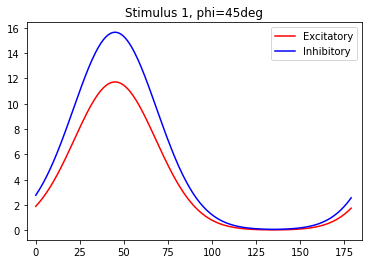

In [360]:
r_E_SS, r_I_SS, R_E_SS, R_I_SS, xs, ts = integrate(t0=0, T=500, dt=0.1, phi=45, N=180, tau_E=20, tau_I=10, J_EE=0.044, J_II=0.018, J_EI=0.023, J_IE=0.042, sigma_ori=32, sigma_FF=30, k=0.04, n=2.0, c=10)
plt.plot(xs, r_E_SS, label='Excitatory', color='r')
plt.plot(xs, r_I_SS, label='Inhibitory', color='b')
plt.title('Stimulus 1, phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

Check out the transfer function:

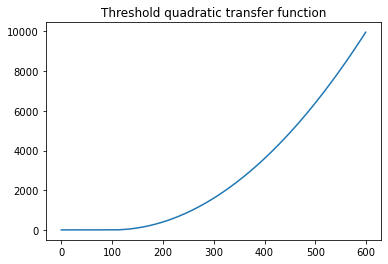

In [361]:
xs = np.arange(-100,500)
plt.plot(xfer(0.04, 2, xs))
plt.title('Threshold quadratic transfer function')
plt.show()

Derivative of transfer function:

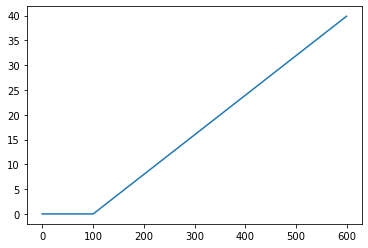

In [362]:
plt.plot(np.diff(xfer(0.04, 2, xs), prepend=0))
plt.show()

We need the derivative of the transfer function in order to compute the linearized system. (Choosing to do the derivative as an interpolation of the numerical derivative since this may allow testing of alternative/more complicated transfer functions in the future.)

In [363]:
df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(xfer(0.04,2,xs), prepend=0))

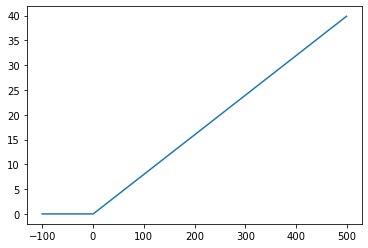

In [364]:
plt.plot(xs, df(xs))
plt.show()

To compute the linearization, we will have to evaluate $\frac{df}{dI}\Bigg|_{I = I_{\alpha, \text{ eff}}}$ where $I_{\alpha, \text{ eff}} = c\mathbf{h} + \mathbf{W}_{\alpha E}\cdot \overline{\mathbf{r}}_E -\mathbf{W}_{\alpha I}\cdot \overline{\mathbf{r}}_I$. Below is what this derivative looks like for $\alpha = E$:

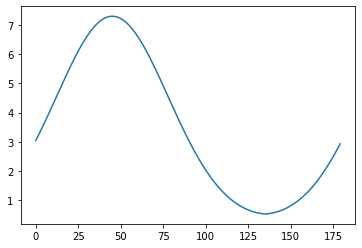

In [365]:
plt.plot(df(c*h + W_EE@r_E_SS - W_EI@r_I_SS))
plt.show()

and for $\alpha = I:$

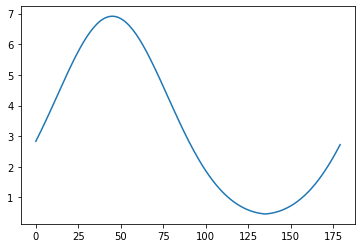

In [366]:
plt.plot(df(c*h + W_IE@r_E_SS - W_II@r_I_SS))
plt.show()

Now we compute the diagonal matrices $\mathbf{L}_E$ and $\mathbf{L}_I$ whose diagonal entries are the derivatives evaluated above.

In [367]:
L_E = np.diagflat(np.array(df(c*h + W_EE@r_E_SS - W_EI@r_I_SS)))
L_I = np.diagflat(np.array(df(c*h + W_IE@r_E_SS - W_II@r_I_SS)))

Next we compute the $\mathbf{W}$ and $\mathbf{D}$ matrices

In [370]:
W = np.zeros((2*N, 2*N))
W[:N, :N] = -np.identity(N) + L_E@W_EE
W[N:, :N] = L_I@W_IE
W[:N, N:] = -L_E@W_EI
W[N:, N:] = -np.identity(N) - L_I@W_II
W_inv = np.linalg.inv(W)

In [371]:
D = np.zeros((2*N, 2*N))
D[:N, :N] = c_ne*L_E # c_ne = c_ni = 1, from noisy sim below
D[N:, N:] = c_ni*L_I
D = np.sqrt(2*tau_n)*D # taun = 1, from noisy sim below

Then the long-term covariance matrix is computed $\boldsymbol{\Sigma} = \mathbf{W}^{-1}\mathbf{D}(\mathbf{W}^{-1}\mathbf{D})^T$:

In [382]:
Sigma = W_inv @ D @ ((W_inv@D).T)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_E = Sigma[:N,:N]
Sigma_E_inv = np.linalg.inv(Sigma_E)

Plotting the covariance matrix:

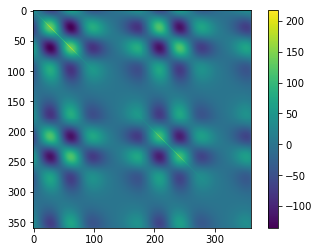

In [383]:
plt.imshow(Sigma)
plt.colorbar()
plt.show()

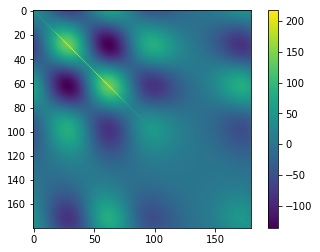

In [384]:
plt.imshow(Sigma_E)
plt.colorbar()
plt.show()

We compute the gain $\mathbf{G}_E = \frac{d\mathbf{r}_E}{ds}$ where $\mathbf{s}(\theta) = c\mathbf{h}(\theta)$.

In [385]:
ds = np.diff(c*h, prepend=0)
dr = np.diff(r_E_SS, prepend=0)
G_E = dr/ds

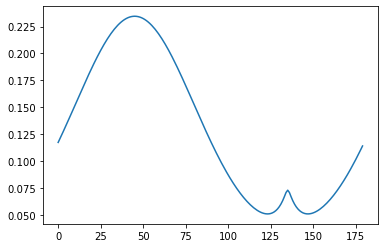

In [386]:
plt.plot(G_E)
plt.show()

Fisher information computation for the E pop is $FI_E = \mathbf{G}_E^T \mathbf{\Sigma}_E^{-1}\mathbf{G}_E$:

In [387]:
FI_E = (((G_E.T)@Sigma_E_inv@G_E).flatten())[0]
print(f'FI_E = {FI_E}')

FI_E = 2.0093981008781245


In [43]:
# noisy version
t0=0
T=500
dt=0.1

phi=45

N=180
Ne=180
Ni=180

tau_E=20
tau_I=10
tau_n=1

c_ne=1
c_ni=1

J_EE=0.044
J_II=0.018
J_EI=0.023
J_IE=0.042

sigma_ori=32
sigma_FF=30

k=0.04
n=2.0

c=50

r_E = np.zeros((Ne,1)) # firing rate vector of E neurons
r_I = np.zeros((Ni,1)) # firing rate vector of I neurons
zero = np.zeros((N,1)) # Nx1 zero vector
xs = np.linspace(0, 179, 180)

xe = np.zeros((Ne,1))
xi = np.zeros((Ni,1))

R_E = r_E # these will store firing rates at each timestep as columns
R_I = r_I 

G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
h = h[:,None] # makes shape (180,1)
W_EE = J_EE*G_ori
W_EI = -J_EI*G_ori
W_IE = J_IE*G_ori
W_II = -J_II*G_ori


I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
I_I = c*h + W_IE@r_E + W_II@r_I
#rE_SS = k*(np.power(np.maximum(I_E, zero), n)) # initial steady state rates
#rI_SS = k*(np.power(np.maximum(I_I, zero), n))

M = int(T/dt)
ts = np.arange(M+1)

r_exc = []
r_inh = []

for m in range(M):
    # smoothed white noise process
    n_e = np.random.randn(Ne,1)
    n_i = np.random.randn(Ni,1)
    xe = xe + (1/tau_n)*(-xe*dt + np.sqrt(2*tau_n*dt)*n_e)
    xi = xi + (1/tau_n)*(-xi*dt + np.sqrt(2*tau_n*dt)*n_i)

    
    r_E = r_E + dt*(1/tau_E)*(-r_E + xfer(k, n, I_E))
    r_I = r_I + dt*(1/tau_I)*(-r_I + xfer(k, n, I_I))

    I_E = c*h + W_EE@r_E + W_EI@r_I + c_ne*xe
    I_I = c*h + W_IE@r_E + W_II@r_I + c_ni*xi

    rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
    rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
    R_E = np.c_[R_E, r_E]
    R_I = np.c_[R_I, r_I]

KeyboardInterrupt: 

In [266]:
def xcov(x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    return 1/M*signal.correlate(x-xbar, y-ybar, mode='full')

## Some plots of the time series

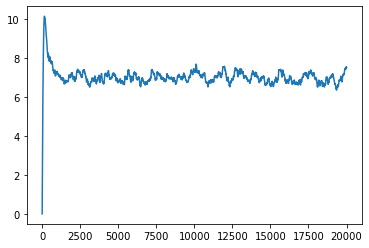

In [253]:
plt.plot(R_E[12,:])
plt.show()

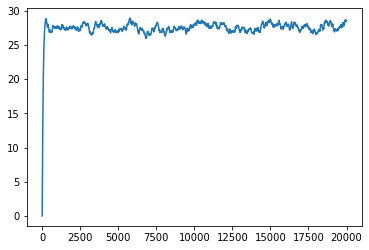

In [254]:
plt.plot(R_E[30,:])
plt.show()

## Covariance plots

In [268]:
W_EE.shape

(180, 180)

In [270]:
W_EI.shape

(180, 180)

In [403]:
W1 = np.append(W_EE, W_IE, axis=1)
W2 = np.append(W_EI, W_II, axis=1)
W = np.append(W1, W2, axis=0)

In [404]:
def xcov(s, Re, Ri, W):
    R = np.append(Re, Ri, axis=0)
    cov = np.cov(R)
    S = np.diag(np.diag(cov))
    if s > 0: 
        return (np.exp(W*s))@S
    else: 
        return S@(np.exp(-W.T*s))

In [405]:
R = np.append(R_E, R_I, axis=0)
cov = np.cov(R)
S = np.diag(np.diag(cov))

In [336]:
((np.exp(W))@np.cov(R)).shape

(360, 360)

In [ ]:
lst = np.array([xcov])

In [423]:
for s in range(-98, 100):
    Cs = np.dstack((Cs, xcov(s, R_E[:,2000:], R_I[:,2000:], W)))

In [425]:
np.trapz(Cs[0,0,:])

29.420263456666675

In [419]:
pd.DataFrame(xcov(100, R_E[:,2000:], R_I[:,2000:], W))

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.669780,0.671997,1.065132,1.312586,1.805411,1.503942,2.133530,1.890025,2.623114,2.296121,...,1.493116,1.481580,2.029664,2.206449,2.852174,3.616091,4.115586,4.448845,5.232228,7.220773
1,0.668343,0.673442,1.072011,1.326717,1.832600,1.533010,2.183788,1.942443,2.706651,2.378511,...,1.433416,1.427362,1.962500,2.141400,2.778661,3.536609,4.041064,4.385819,5.179019,7.176539
2,0.664055,0.671997,1.074316,1.335286,1.852329,1.556096,2.225996,1.988200,2.781716,2.454258,...,1.371421,1.370292,1.890684,2.070539,2.696742,3.445454,3.952241,4.306403,5.105649,7.103558
3,0.656982,0.667685,1.072011,1.338157,1.864292,1.572849,2.259519,2.026628,2.847244,2.522323,...,1.307804,1.311027,1.815088,1.994769,2.607504,3.343878,3.850374,4.211749,5.013200,7.002923
4,0.647234,0.660574,1.065132,1.335286,1.868301,1.583007,2.283845,2.057148,2.902275,2.581741,...,1.243212,1.250211,1.736586,1.915012,2.512084,3.233226,3.736859,4.103192,4.903010,6.876119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.000848,0.000863,0.001396,0.001768,0.002514,0.002179,0.003235,0.003018,0.004436,0.004135,...,0.004621,0.004383,0.005770,0.006061,0.007613,0.009432,0.010550,0.011272,0.013180,0.018188
356,0.000839,0.000852,0.001376,0.001739,0.002468,0.002135,0.003164,0.002946,0.004322,0.004022,...,0.004665,0.004418,0.005806,0.006088,0.007633,0.009440,0.010540,0.011242,0.013122,0.018077
357,0.000833,0.000844,0.001360,0.001715,0.002428,0.002096,0.003100,0.002881,0.004218,0.003919,...,0.004718,0.004460,0.005851,0.006125,0.007667,0.009465,0.010550,0.011233,0.013088,0.017998
358,0.000828,0.000837,0.001346,0.001694,0.002394,0.002062,0.003043,0.002822,0.004125,0.003825,...,0.004779,0.004510,0.005907,0.006174,0.007714,0.009507,0.010578,0.011242,0.013076,0.017951


In [420]:
Cs = np.dstack((xcov(-100, R_E[:,2000:], R_I[:,2000:], W), xcov(-99, R_E[:,2000:], R_I[:,2000:], W)))

In [370]:
np.dstack((arr0,arr1))

array([[[ 1.87640761,  1.92427258],
        [ 1.87640761,  4.56595985],
        [ 1.87640761,  1.20891505],
        ...,
        [ 1.87640761, 39.79210465],
        [ 1.87640761, 47.03846331],
        [ 1.87640761, 56.8629389 ]],

       [[ 4.51869636,  1.92511658],
        [ 4.51869636,  4.56675083],
        [ 4.51869636,  1.20989607],
        ...,
        [ 4.51869636, 39.79086724],
        [ 4.51869636, 47.03699468],
        [ 4.51869636, 56.86084919]],

       [[ 1.15598101,  1.92594309],
        [ 1.15598101,  4.56752223],
        [ 1.15598101,  1.21086014],
        ...,
        [ 1.15598101, 39.78962508],
        [ 1.15598101, 47.03551573],
        [ 1.15598101, 56.85875158]],

       ...,

       [[39.84164617,  1.84494705],
        [39.84164617,  4.46573913],
        [39.84164617,  1.1283919 ],
        ...,
        [39.84164617, 39.5410477 ],
        [39.84164617, 46.73738613],
        [39.84164617, 56.51967416]],

       [[47.09418779,  1.84546228],
        [47.09418779,  4.46

In [364]:
arr = arr.reshape(360,360,1)

ValueError: cannot reshape array of size 129600 into shape (360,360,2)

In [363]:
np.append(arr, xcov(1, R_E, R_I, W), axis=2)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [342]:
pd.DataFrame(xcov(0, R_E, R_I, W))

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,...,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408,1.876408
1,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,...,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696,4.518696
2,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,...,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981,1.155981
3,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,...,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214,8.569214
4,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,...,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401,8.149401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,...,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885,27.900885
356,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,...,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883,32.838883
357,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,...,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646,39.841646
358,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,...,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188,47.094188


In [323]:
np.trapz(xcov(1, R_E, R_I, W))

224415.6460535042

In [300]:
R = np.append(R_E, R_I, axis=0)
S = np.diag(np.cov(R))

In [301]:
M

20000

In [310]:
C = xcov(350, R_E[0,:], R_E[20,:], W, S)

In [311]:
pd.DataFrame(C)

,0
0,7.134078e+06
1,8.033075e+06
2,9.033101e+06
3,1.014618e+07
4,1.138582e+07
...,...
355,1.338818e+02
356,1.260236e+02
357,1.184487e+02
358,1.111631e+02


In [279]:
np.var(R_E[0,:])

0.04450959774328172

In [280]:
np.var(R_I[1,:])

0.23186330891825446

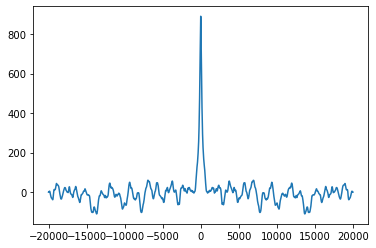

In [263]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[0,:], R_E[0,:]))
plt.show()

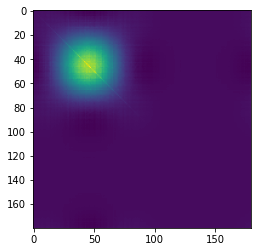

In [265]:
plt.imshow(np.cov(R_E))

In [264]:
pd.DataFrame(np.cov(R_E))

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.044512,0.040986,0.037600,0.045374,0.047413,0.041506,0.042912,0.053424,0.045794,0.044529,...,0.013581,0.015626,0.019656,0.021348,0.018711,0.025642,0.025942,0.026708,0.033034,0.038495
1,0.040986,0.056430,0.042625,0.049548,0.053709,0.049518,0.047562,0.060151,0.054075,0.048963,...,0.015410,0.017444,0.022733,0.024228,0.020825,0.028709,0.031149,0.028029,0.035602,0.042953
2,0.037600,0.042625,0.054439,0.044629,0.047194,0.042317,0.046801,0.059017,0.046604,0.043007,...,0.014096,0.016134,0.021224,0.022607,0.020008,0.025352,0.028251,0.028456,0.034429,0.037203
3,0.045374,0.049548,0.044629,0.071302,0.059767,0.052129,0.054255,0.065043,0.065767,0.060081,...,0.015778,0.018649,0.023615,0.025523,0.022510,0.030889,0.032778,0.031838,0.039694,0.044422
4,0.047413,0.053709,0.047194,0.059767,0.080826,0.052057,0.060650,0.065077,0.065005,0.058820,...,0.017507,0.018956,0.024039,0.026858,0.023471,0.033247,0.033126,0.033809,0.042939,0.047422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.025642,0.028709,0.025352,0.030889,0.033247,0.027189,0.027380,0.032560,0.030063,0.027201,...,0.009802,0.011025,0.014277,0.015440,0.013270,0.020548,0.018251,0.018701,0.021805,0.025018
176,0.025942,0.031149,0.028251,0.032778,0.033126,0.028219,0.031414,0.037716,0.030857,0.029179,...,0.010221,0.011586,0.014671,0.015938,0.013632,0.018251,0.023511,0.018348,0.022654,0.026158
177,0.026708,0.028029,0.028456,0.031838,0.033809,0.028808,0.030844,0.034878,0.029943,0.028131,...,0.010064,0.011505,0.014784,0.016089,0.013999,0.018701,0.018348,0.023847,0.023637,0.025865
178,0.033034,0.035602,0.034429,0.039694,0.042939,0.032758,0.036424,0.047642,0.041629,0.036546,...,0.011990,0.013862,0.018210,0.018384,0.016940,0.021805,0.022654,0.023637,0.035821,0.032232


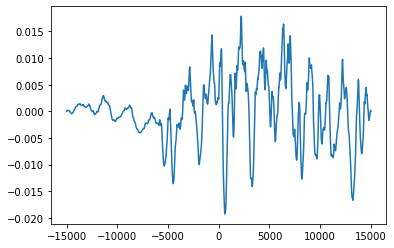

In [199]:
plt.plot(np.arange(-R_E_trim[0,:].shape[0]+1, R_E_trim[0,:].shape[0]), xcov(R_E_trim[100,:], R_E_trim[123,:]))
plt.show()

In [239]:
Sigma_E = np.zeros((N,N))
for i in range(N):
    #print(i)_trim
    for j in range(N):
        Sigma_E[i,j] = np.trapz(xcov(R_E[i,:],R_E[j,:]))
        
Sigma_E_inv = np.linalg.inv(Sigma_E)
dh = np.diff(h, axis=0, prepend=0)

FI_E = dh.T@Sigma_E_inv@dh
print(FI_E)

[[-7.96642606e+10]]


In [241]:
pd.DataFrame(Sigma_E)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,2.970159e+08,3.682589e+08,4.345312e+08,5.259015e+08,6.138100e+08,7.086206e+08,8.291313e+08,9.717798e+08,1.103393e+09,1.254154e+09,...,1.851863e+07,2.942731e+07,3.990336e+07,5.337065e+07,6.968727e+07,9.112177e+07,1.190697e+08,1.630999e+08,2.015469e+08,2.459893e+08
1,3.682589e+08,4.565904e+08,5.387590e+08,6.520455e+08,7.610401e+08,8.785922e+08,1.028009e+09,1.204873e+09,1.368055e+09,1.554979e+09,...,2.296055e+07,3.648582e+07,4.947468e+07,6.617227e+07,8.640263e+07,1.129785e+08,1.476301e+08,2.022215e+08,2.498905e+08,3.049929e+08
2,4.345312e+08,5.387590e+08,6.357147e+08,7.693884e+08,8.979977e+08,1.036705e+09,1.213011e+09,1.421704e+09,1.614252e+09,1.834814e+09,...,2.709256e+07,4.305185e+07,5.837821e+07,7.808071e+07,1.019518e+08,1.333102e+08,1.741978e+08,2.386135e+08,2.948611e+08,3.598798e+08
3,5.259015e+08,6.520455e+08,7.693884e+08,9.311701e+08,1.086823e+09,1.254696e+09,1.468074e+09,1.720650e+09,1.953686e+09,2.220627e+09,...,3.278940e+07,5.210450e+07,7.065357e+07,9.449899e+07,1.233895e+08,1.613418e+08,2.108269e+08,2.887875e+08,3.568625e+08,4.355528e+08
4,6.138100e+08,7.610401e+08,8.979977e+08,1.086823e+09,1.268493e+09,1.464428e+09,1.713474e+09,2.008270e+09,2.280260e+09,2.591822e+09,...,3.827040e+07,6.081417e+07,8.246387e+07,1.102952e+08,1.440150e+08,1.883113e+08,2.460683e+08,3.370606e+08,4.165148e+08,5.083589e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,9.112177e+07,1.129785e+08,1.333102e+08,1.613418e+08,1.883113e+08,2.173983e+08,2.543699e+08,2.981331e+08,3.385108e+08,3.847630e+08,...,5.681346e+06,9.028030e+06,1.224199e+07,1.637363e+07,2.137942e+07,2.795533e+07,3.652951e+07,5.003756e+07,6.183276e+07,7.546726e+07
176,1.190697e+08,1.476301e+08,1.741978e+08,2.108269e+08,2.460683e+08,2.840766e+08,3.323877e+08,3.895736e+08,4.423354e+08,5.027737e+08,...,7.423872e+06,1.179702e+07,1.599673e+07,2.139559e+07,2.793670e+07,3.652951e+07,4.773348e+07,6.538459e+07,8.079749e+07,9.861383e+07
177,1.630999e+08,2.022215e+08,2.386135e+08,2.887875e+08,3.370606e+08,3.891238e+08,4.552997e+08,5.336320e+08,6.059043e+08,6.886918e+08,...,1.016911e+07,1.615937e+07,2.191207e+07,2.930735e+07,3.826727e+07,5.003756e+07,6.538459e+07,8.956282e+07,1.106752e+08,1.350797e+08
178,2.015469e+08,2.498905e+08,2.948611e+08,3.568625e+08,4.165148e+08,4.808507e+08,5.626260e+08,6.594233e+08,7.487322e+08,8.510349e+08,...,1.256624e+07,1.996857e+07,2.707734e+07,3.621588e+07,4.728789e+07,6.183276e+07,8.079749e+07,1.106752e+08,1.367643e+08,1.669216e+08


In [58]:
np.diff(R_E[1,:])

array([ 5.81774014e-02,  5.67673059e-02,  5.69959560e-02, ...,
       -1.49703324e-05,  8.22735337e-05, -1.42789688e-04])

In [201]:
np.diff(R_E_trim[1,:]).T@(np.linalg.inv(Sigma_E))@np.diff(R_E_trim[1,:])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 180 is different from 14999)

In [62]:
dR_E = np.diff(R_E)

In [ ]:
dR_E

In [64]:
h.shape

(180, 1)

In [72]:
dh = np.diff(h, axis=0, prepend=0)

In [75]:
Sigma_inv = np.linalg.inv(Sigma)

In [76]:
dh.T@Sigma_inv@dh

array([[-3.09062151e+10]])